In [2]:
import healpy as hp
import numpy as np
import pymaster as nmt

def downgrade_alm(input_alm,nside_in,nside_out):
    """
    This is a Function to downgrade Alm correctly.
    nside_in must be bigger than nside_out.
    In this function, lmax_in = 3*nside_in-1 , lmax_out = 3*nside_out-1 .
    input_alm must be lmax = lmax_in and output_alm must be lmax = lmax_out.
    This function get only values in the range 0 < l < lmax_out from input_alm,
    and put these values into output_alm which has range 0 < l < lmax_out.
    """
    lmax_in = nside_in*3-1
    lmax_out = nside_out*3-1
    output_alm = np.zeros((3,hp.sphtfunc.Alm.getsize(lmax_out)),dtype=complex)
    
    for m in range(lmax_out+1):
        idx_1_in = hp.sphtfunc.Alm.getidx(lmax_in,m ,m)
        idx_2_in = hp.sphtfunc.Alm.getidx(lmax_in,lmax_out ,m)

        idx_1_out = hp.sphtfunc.Alm.getidx(lmax_out,m ,m)
        idx_2_out = hp.sphtfunc.Alm.getidx(lmax_out,lmax_out ,m)

        output_alm[:,idx_1_out:idx_2_out+1] = input_alm[:,idx_1_in:idx_2_in+1]
    return output_alm

def downgrade_map(input_map,nside_out,nside_in):
    """
    This is a Function to downgrade map correctly in harmonic space.
    nside_in must be bigger than nside_out.
    input_map must have nside_in.
    output_map has nside_out as Nside
    """
    #  nside_in= hp.npix2nside(len(input_map))
    input_alm = hp.map2alm(input_map)  #input map → input alm
    output_alm = downgrade_alm(input_alm,nside_in,nside_out) # input alm → output alm (decrease nside)
    output_map = hp.alm2map(output_alm,nside=nside_out)#  output alm → output map
    return output_map

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled
   

Pr = "/global/homes/l/leovchr/"

nside = 16
Npix = hp.nside2npix(nside)
N=199
lmax = 2*nside+1
#nside*3-1
#lmax=850
scale = 5
Nlbin = 1
fsky = 0.95
complexity='baseline' 	#should be 'baseline', 'high_complexity' or 'medium_complexity'
kw=''
r=0

folder= "/global/cfs/cdirs/litebird/simulations/maps/E_modes_postptep/2ndRelease/coadd_sims/e2e_noise/%s"%complexity
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()

bands = ['LFT_L1-040', 'LFT_L2-050', 'LFT_L1-060', 'LFT_L3-068','LFT_L2-068', 'LFT_L4-078', 'LFT_L1-078', 'LFT_L3-089', 'LFT_L2-089','LFT_L4-100', 'LFT_L3-119', 'LFT_L4-140',
         'MFT_M1-100', 'MFT_M2-119', 'MFT_M1-140', 'MFT_M2-166', 'MFT_M1-195',
         'HFT_H1-195', 'HFT_H2-235', 'HFT_H1-280', 'HFT_H2-337', 'HFT_H3-402']

freq=np.array([40,50,60,68,68,78,78,89,89,100,119,140,100,119,140,166,195,195,235,280,337,402])
N_freqs=len(bands)

folder_masks= "/pscratch/sd/d/delahoz/LiteBIRD/E-mode-paper/cs_products/masks/"
#mask=np.zeros((N_freqs,Npix))
#for f in range(N_freqs):
#    mask0 = hp.read_map(folder_masks+"mask_f%s_smoo5deg_fgdsE%s_nside512.fits"%(int(fsky*100),freq[f]))
#    mask0 = hp.ud_grade(mask0,nside_out=nside)
#    mask[f] = nmt.mask_apodization(mask0, scale, apotype='C2')
    
mask0 = hp.read_map(folder_masks+"mask_f%s_smoo5deg_fgdsP100_nside512.fits"%(int(fsky*100)))
mask0 = hp.ud_grade(mask0,nside_out=nside)
mask = nmt.mask_apodization(mask0, scale, apotype='C2')

In [3]:
maptot= np.zeros((N_freqs,3,Npix))

for i in range(N_freqs):
    maptoti= hp.read_map(folder+"/0000/"+"coadd_maps_LB_%s_cmb_e2e_sims_fg_baseline_wn_1f_binned_030mHz_0000.fits"%bands[i],field=(0,1,2))
    maptot[i]= downgrade_map(maptoti,nside_in=512,nside_out=nside)
maptot=maptot[:,1:]

wsp_dc=[]

for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        w_dc.compute_coupling_matrix(nmt.NmtField(mask, maptot[i]*1,purify_e=True, purify_b=False), nmt.NmtField(mask, maptot[j]*1,purify_e=True, purify_b=False), b)
        wsp_dc.append(w_dc)
        

In [4]:
#generate dust map

if complexity=="baseline":
    folderfg= "/global/cfs/cdirs/litebird/simulations/maps/PTEP_20200801/foregrounds/"
    bands_ptep = ['LFT_40', 'LFT_50', 'LFT_60', 'LFT_68a','LFT_68b', 'LFT_78a', 'LFT_78b', 'LFT_89a', 'LFT_89b','LFT_100', 'LFT_119', 'LFT_140',
         'MFT_100', 'MFT_119', 'MFT_140', 'MFT_166', 'MFT_195',
         'HFT_195', 'HFT_235', 'HFT_280', 'HFT_337', 'HFT_402']

Npix512= hp.nside2npix(512)
maptotdust= np.zeros((N_freqs,3,Npix512))

for i in range(N_freqs):
    if complexity=="baseline":
        maptotdust[i]= hp.read_map(folderfg+"dust/"+"LB_%s_dust_PTEP_20200801.fits"%bands_ptep[i],field=(0,1,2))
    #maptotdust[i]= downgrade_map(maptotdusti,nside_in=512,nside_out=nside)


In [6]:
# CMB spectra:

foldercmb= "/global/cfs/cdirs/litebird/simulations/maps/reference_CMB_spectra"
CLcmb_or=hp.read_cl(foldercmb+'/Cls_Planck2018_r0.fits') #TT EE BB TE
CLcmb_bin= b.bin_cell(CLcmb_or[:,2:lmax+3])

[]

findfont: Font family ['Comics San'] not found. Falling back to DejaVu Sans.


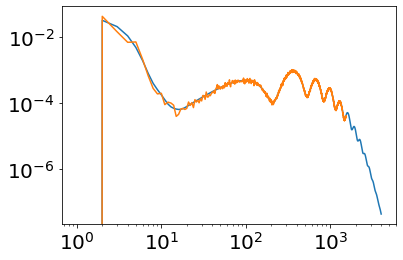

In [7]:
mapcmb0= hp.synfast(CLcmb_or,512,pixwin=False,new=True)
test=hp.anafast(mapcmb0)
plt.plot(CLcmb_or[1])
plt.plot(test[1])
plt.loglog()

In [8]:
noise_folder= '/global/cfs/cdirs/litebird/simulations/maps/E_modes_postptep/2ndRelease/noise_simulations/'
Ncross=int(N_freqs*(N_freqs+1)/2)

CLdc=np.zeros((N,Ncross,len(leff)))
    
maptotdc= np.zeros((N_freqs,3,Npix))

for k in range(0,N):
    a='000'+"%s"%k
    if len(a)>4:
        a=a.replace("000","00")
    if k==100:
        a='0100'
    if k>100:
        a=a.replace("00","0")
    print(a)
    
    mapnoise= np.zeros((N_freqs,3,Npix512))
    mapcmb= np.zeros((N_freqs,3,Npix512))
    mapcmb0= hp.synfast(CLcmb_or,512,pixwin=False,new=True)
    for i in range(N_freqs):
        for f in range(3):
            mapnoise[i,f]= hp.read_map(noise_folder+"%s/%s/LB_%s_binned_wn_1f_030mHz_%s.fits"%(bands[i][0]+'FT',bands[i][4:],bands[i],a),field=f)
            mapcmb[i,f]= mapcmb0[f]
    maptoti= maptotdust + mapnoise + mapcmb
    for i in range(N_freqs):
        maptotdc[i]= downgrade_map(maptoti[i],nside_in=512,nside_out=nside)
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            CLdc[k,z] = np.array((compute_master(nmt.NmtField(mask, 1*maptotdc[i,1:],purify_e=True, purify_b=False), nmt.NmtField(mask,1*maptotdc[j,1:],purify_e=True, purify_b=False), wsp_dc[z]))[0])
            z = z +1
    np.save(Pr+'codes/Moments-EE/DL_EE/DL_EE_dustonly_%s_nside%s.npy'%(complexity,nside),leff*(leff+1)*CLdc/2/np.pi)  

0000
0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036
0037
0038
0039
0040
0041
0042
0043
0044
0045
0046
0047
0048
0049
0050
0051
0052
0053
0054
0055
0056
0057
0058
0059
0060
0061
0062
0063
0064
0065
0066
0067
0068
0069
0070
0071
0072
0073
0074
0075
0076
0077
0078
0079
0080
0081
0082
0083
0084
0085
0086
0087
0088
0089
0090
0091
0092
0093
0094
0095
0096
0097
0098
0099
0100
0101
0102
0103
0104
0105
0106
0107
0108
0109
0110
0111
0112
0113
0114
0115
0116
0117
0118
0119
0120
0121
0122
0123
0124
0125
0126
0127
0128
0129
0130
0131
0132
0133
0134
0135
0136
0137
0138
0139
0140
0141
0142
0143
0144
0145
0146
0147
0148
0149
0150
0151
0152
0153
0154
0155
0156
0157
0158
0159
0160
0161
0162
0163
0164
0165
0166
0167
0168
0169
0170
0171
0172
0173
0174
0175
0176
0177
0178
0179
0180
0181
0182
0183
0184
0185
0186
0187
0188
0189
0190
0191
0192
0193
0194
0195
0196
0197
0198


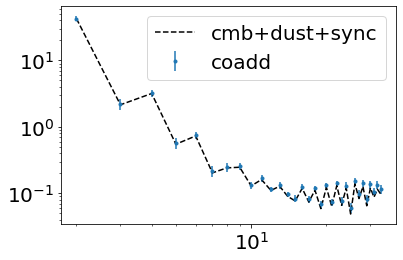

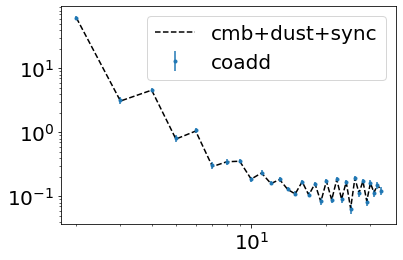

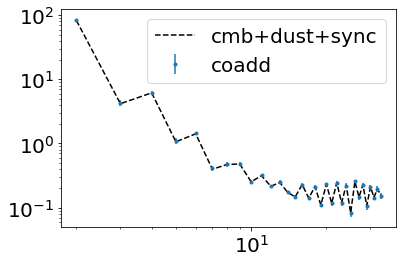

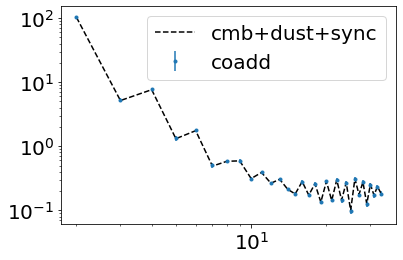

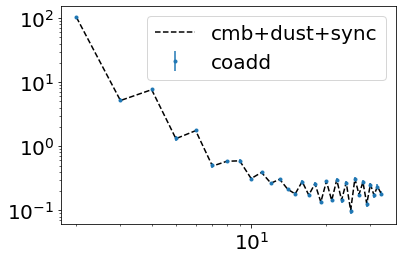

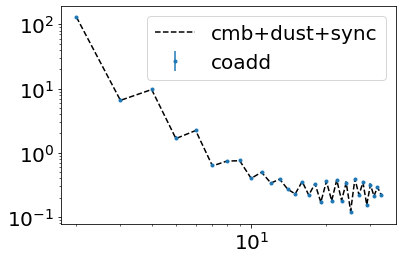

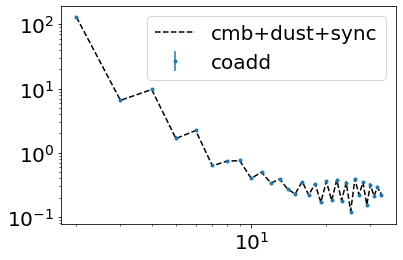

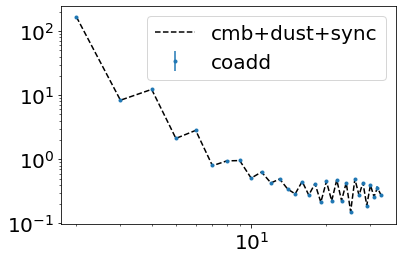

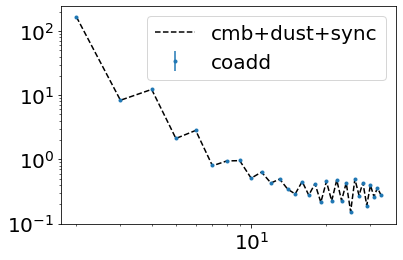

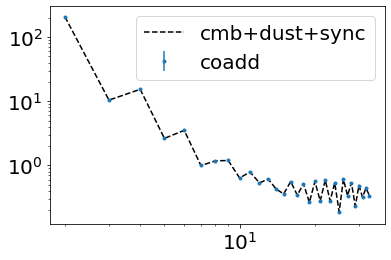

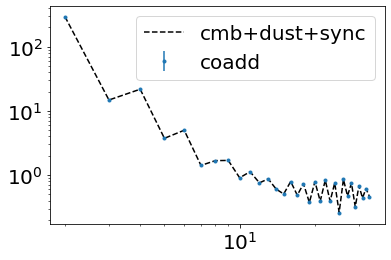

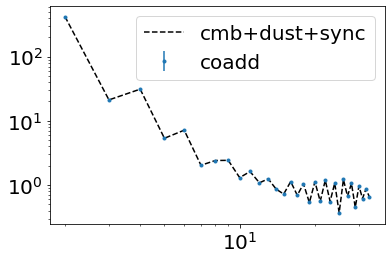

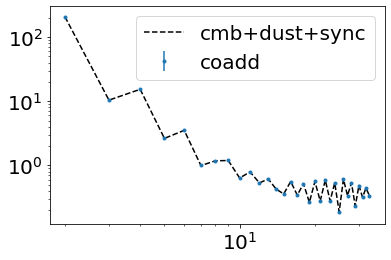

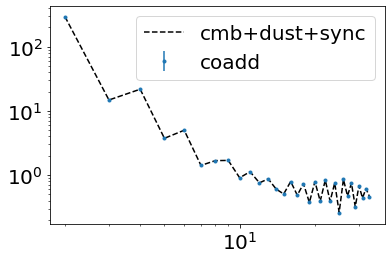

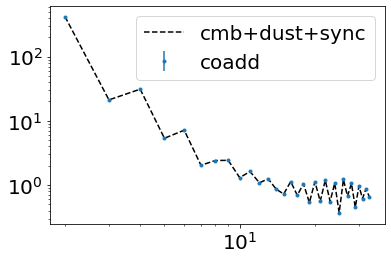

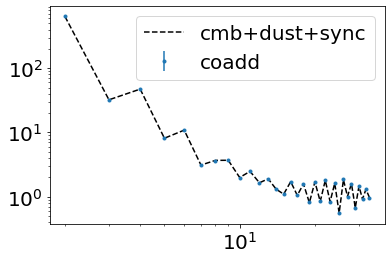

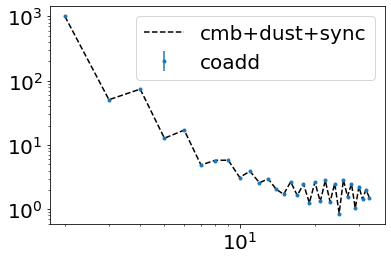

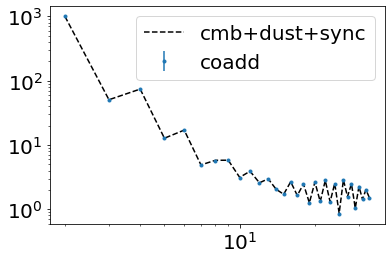

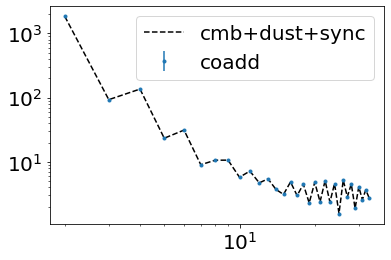

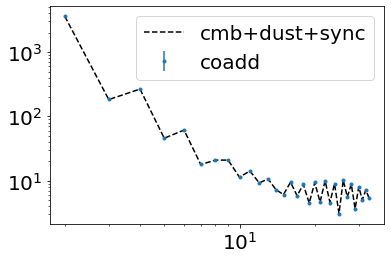

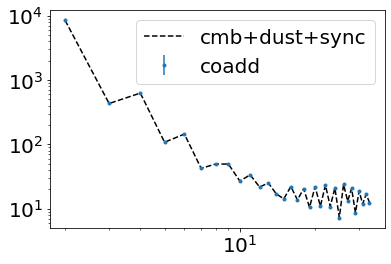

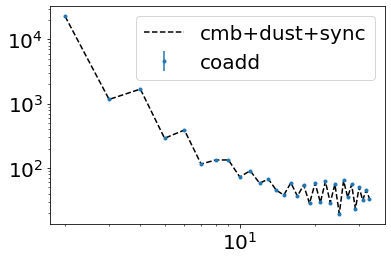

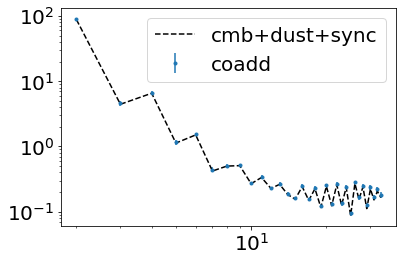

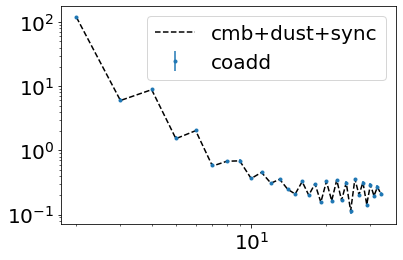

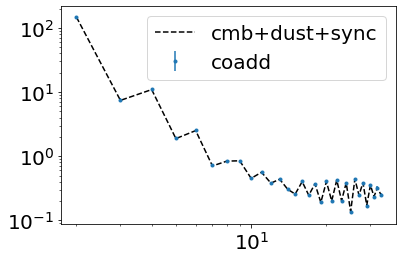

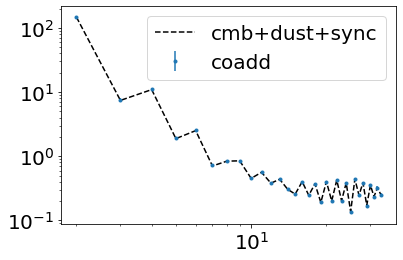

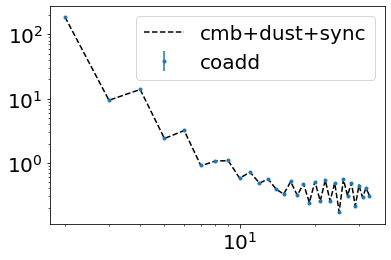

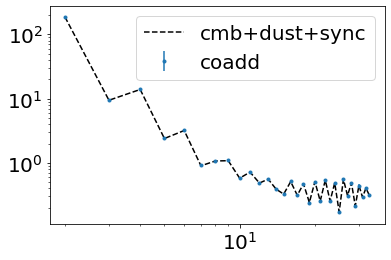

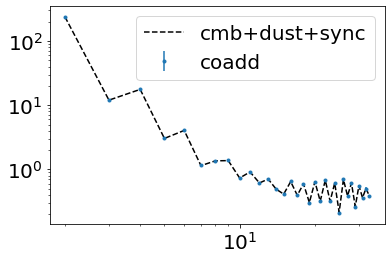

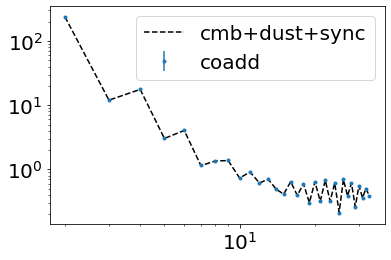

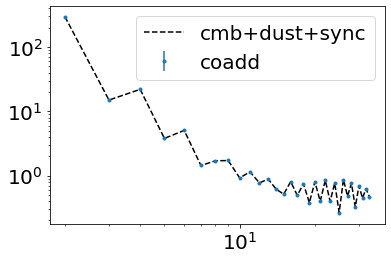

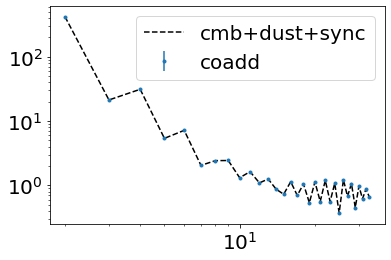

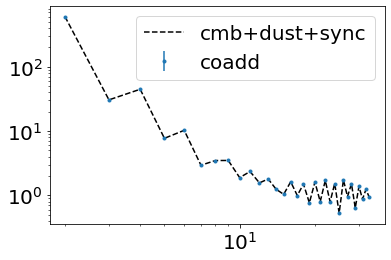

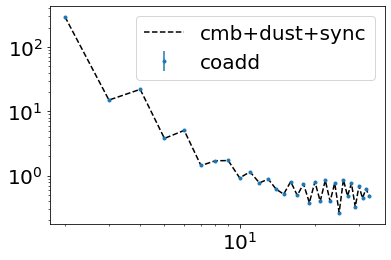

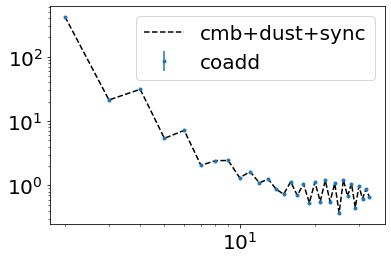

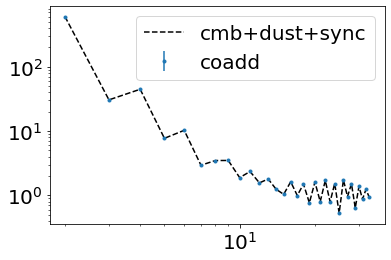

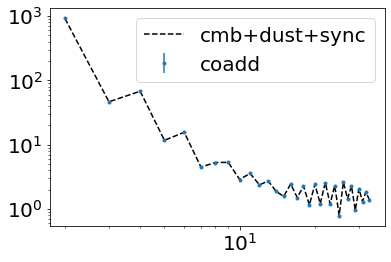

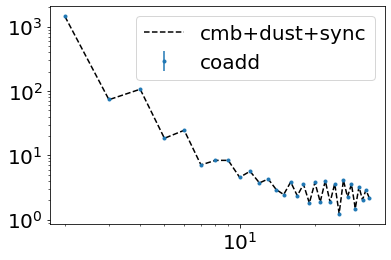

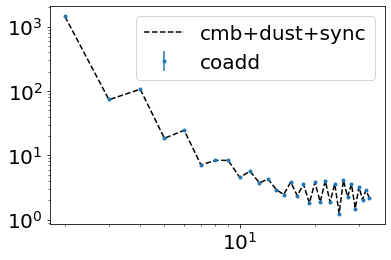

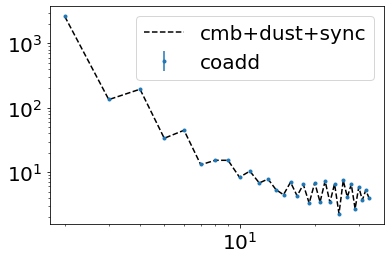

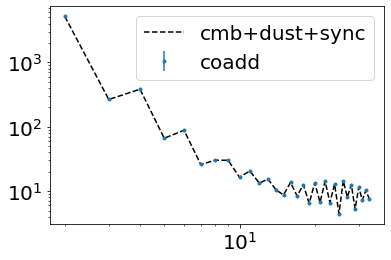

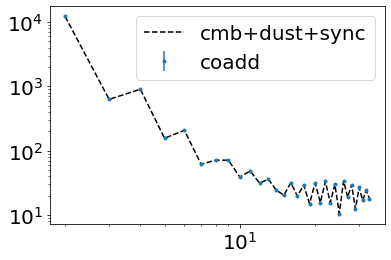

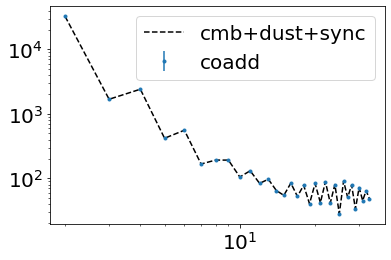

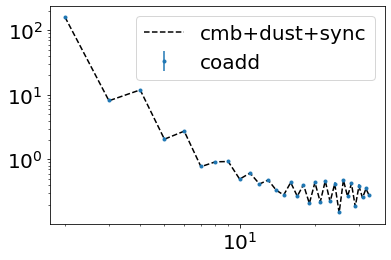

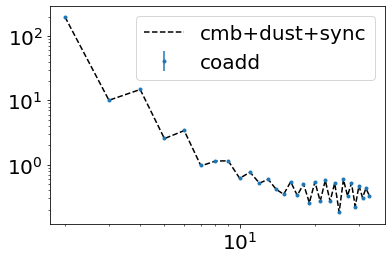

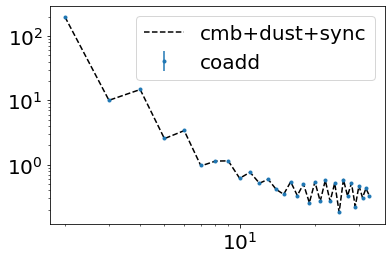

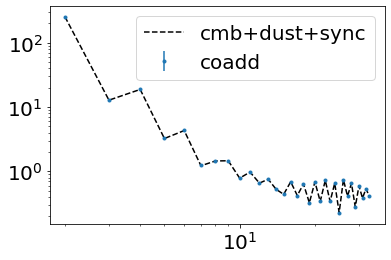

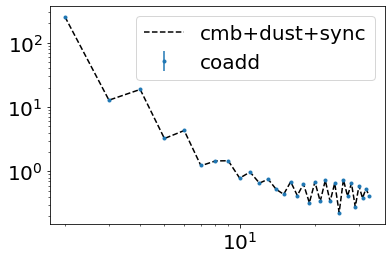

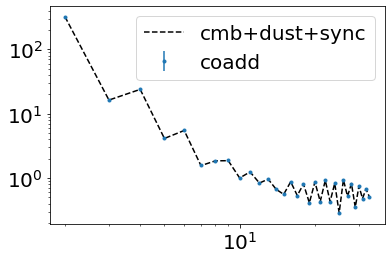

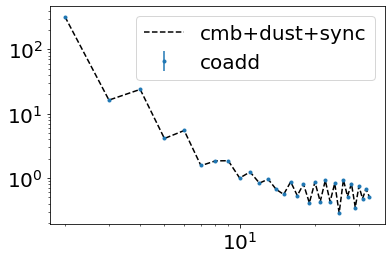

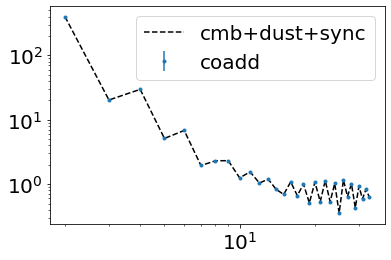

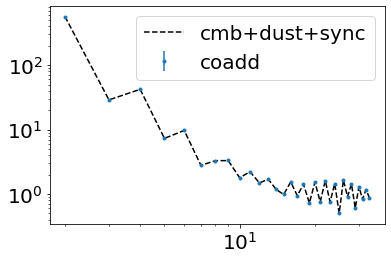

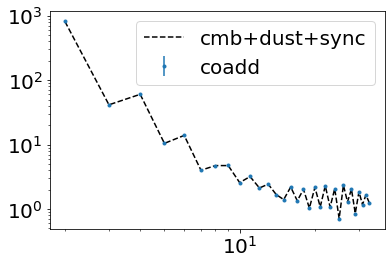

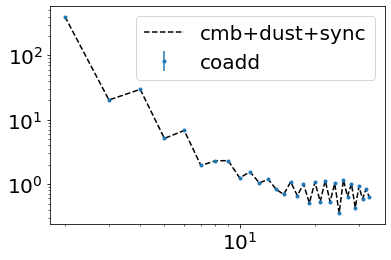

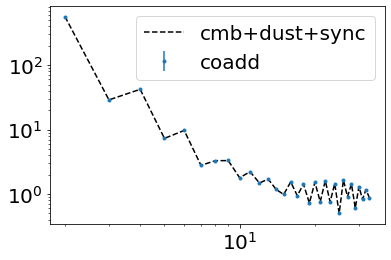

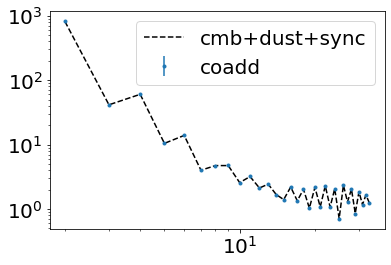

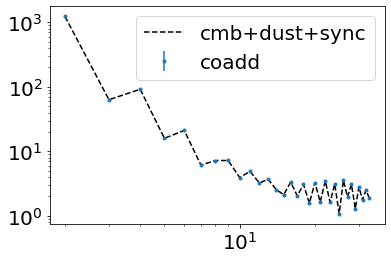

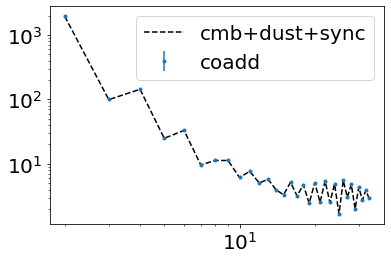

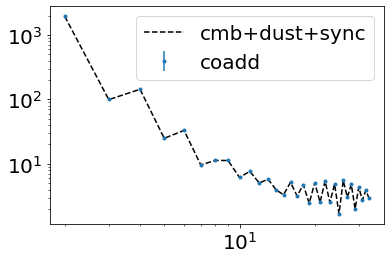

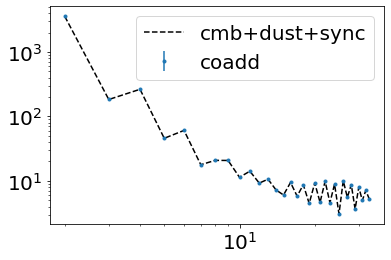

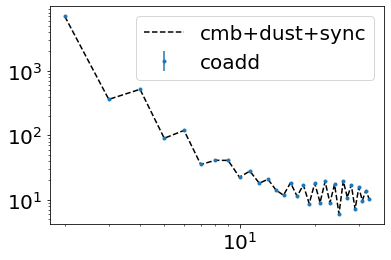

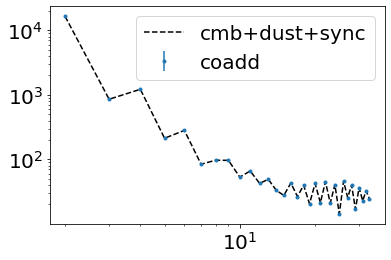

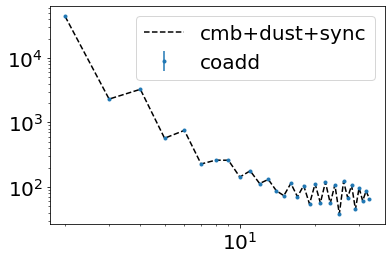

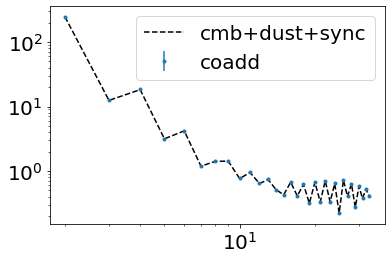

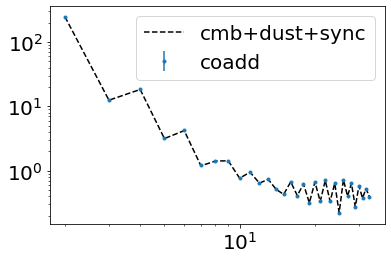

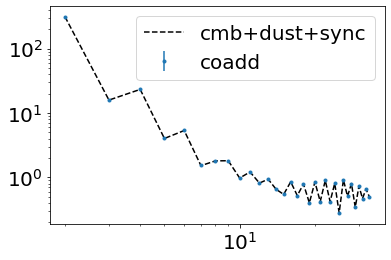

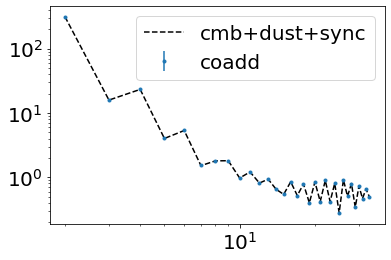

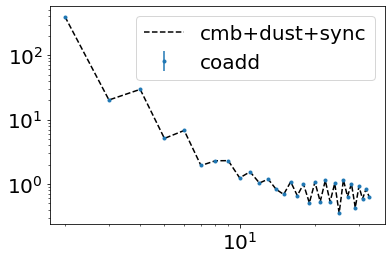

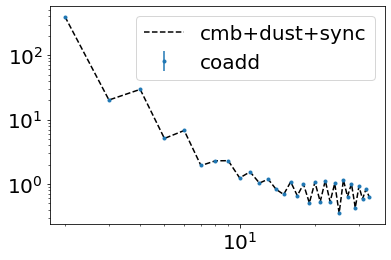

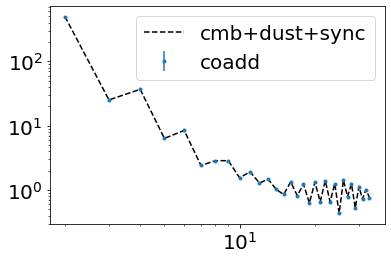

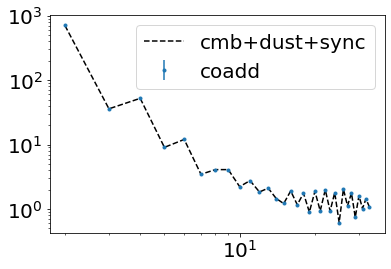

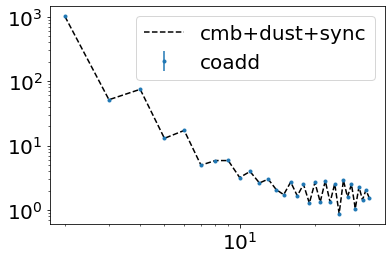

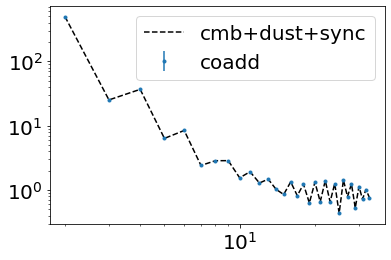

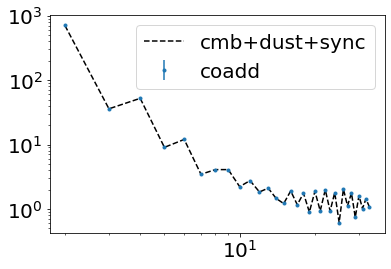

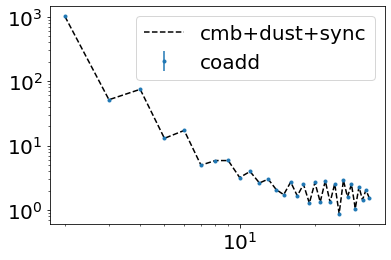

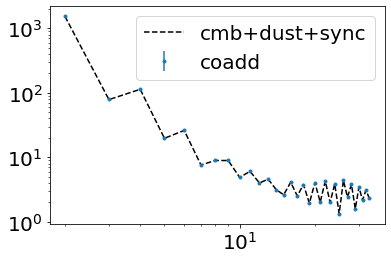

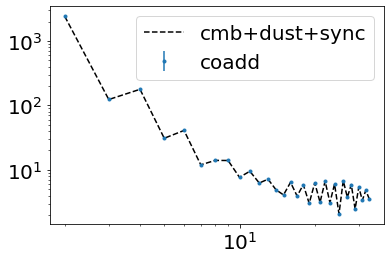

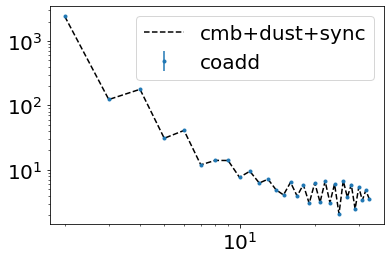

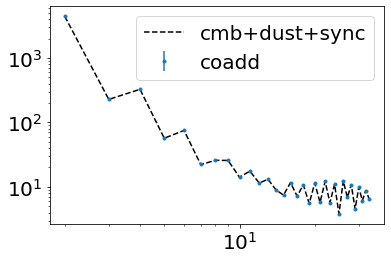

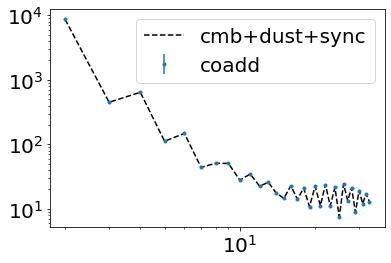

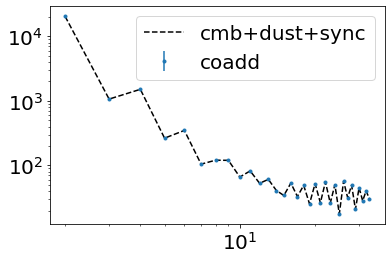

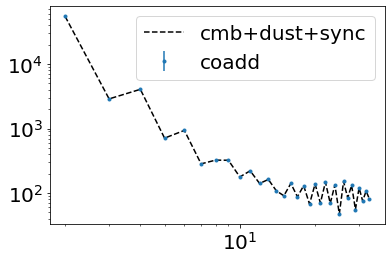

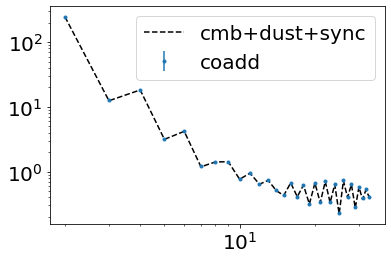

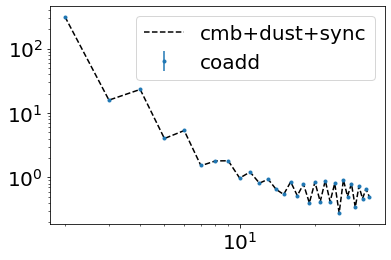

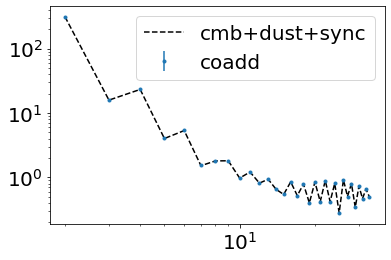

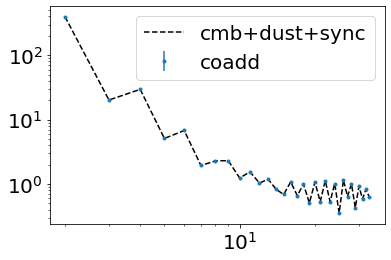

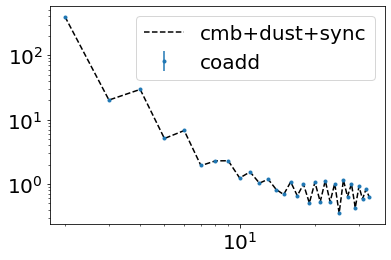

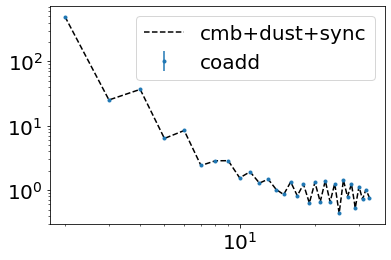

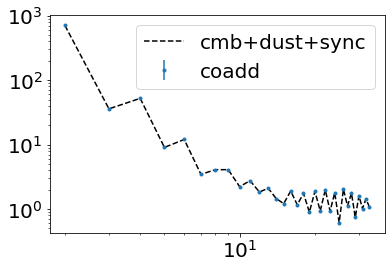

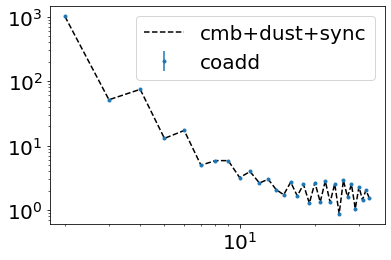

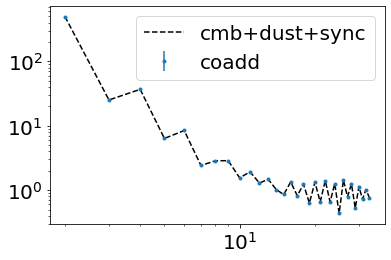

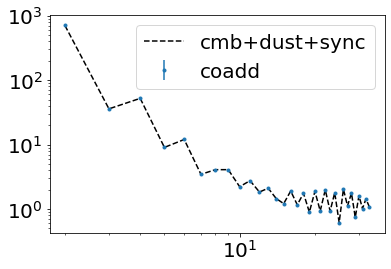

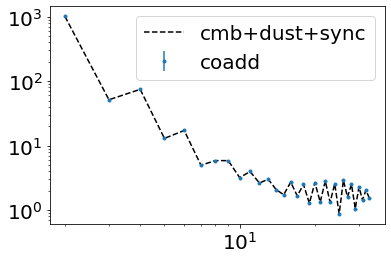

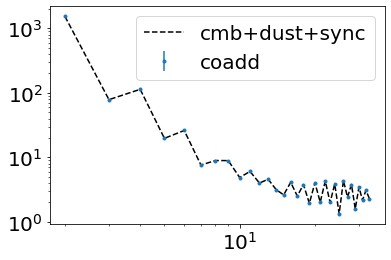

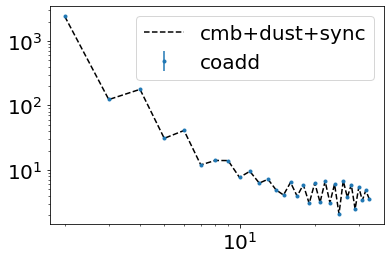

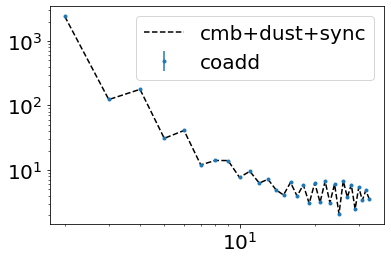

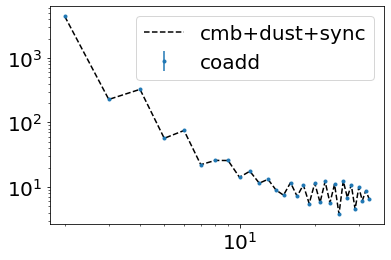

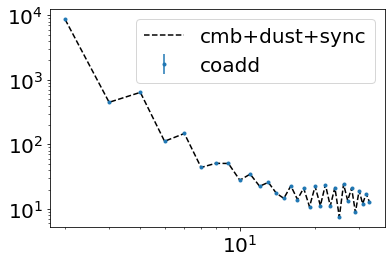

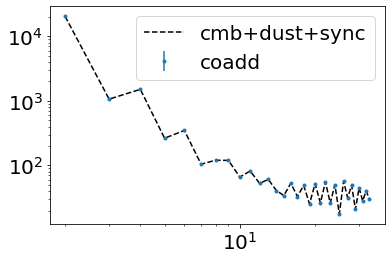

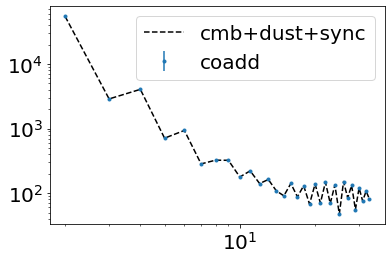

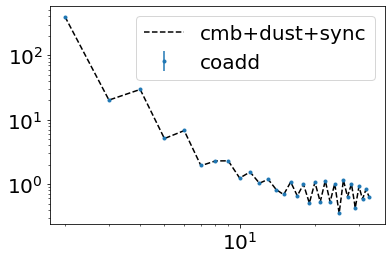

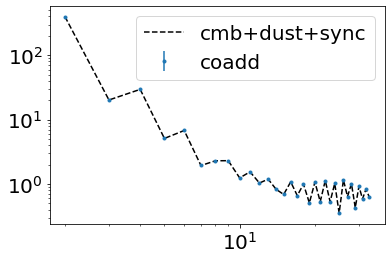

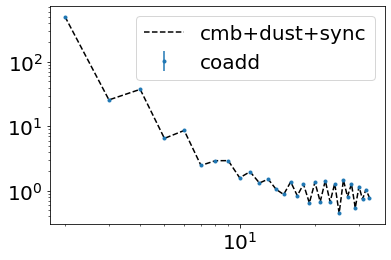

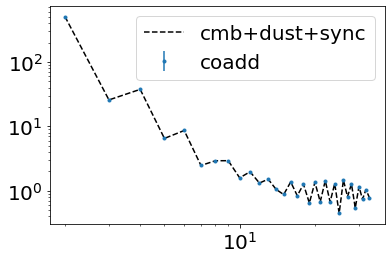

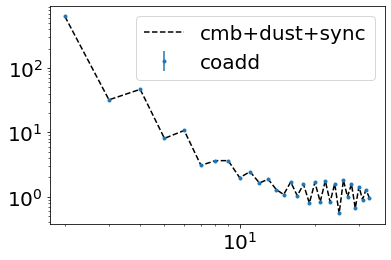

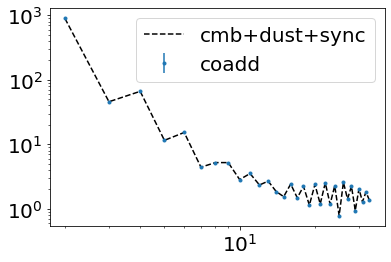

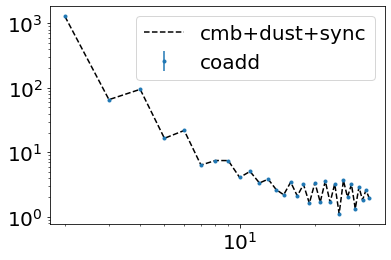

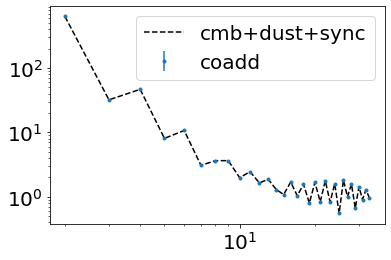

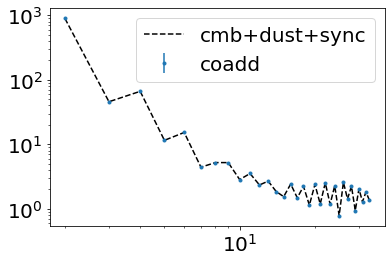

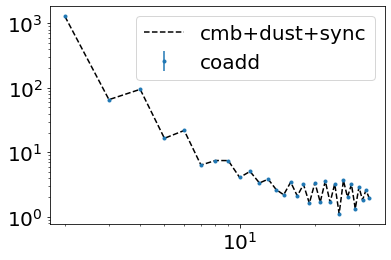

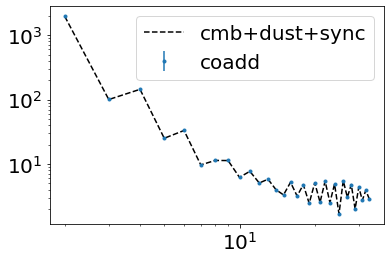

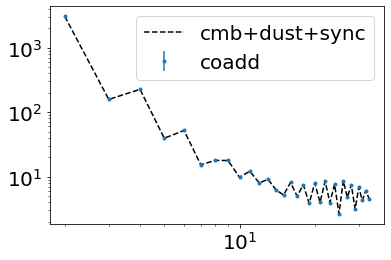

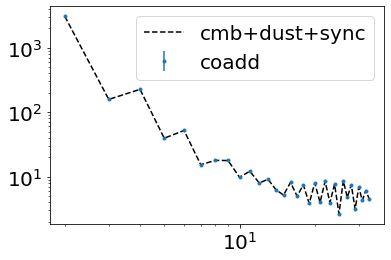

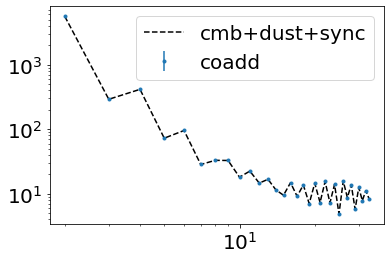

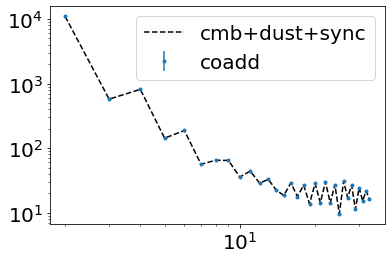

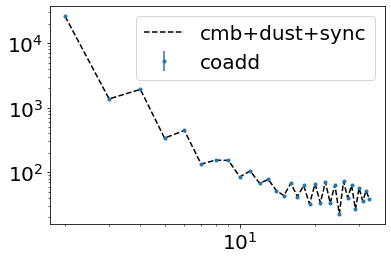

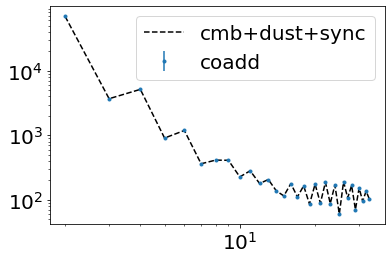

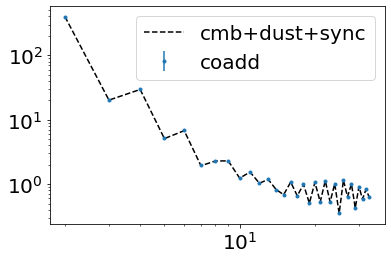

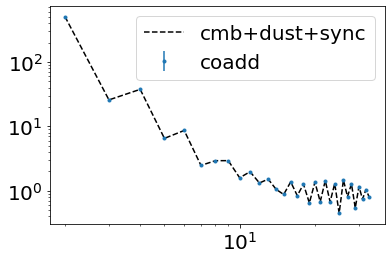

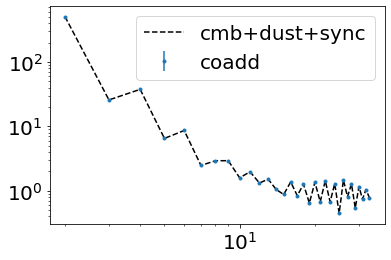

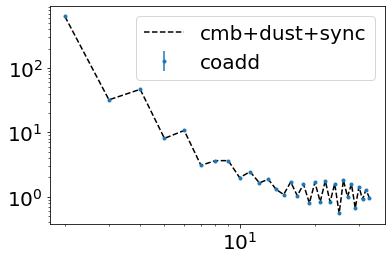

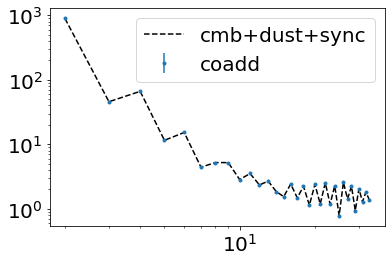

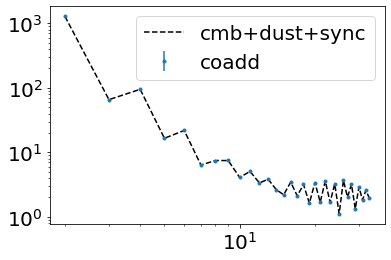

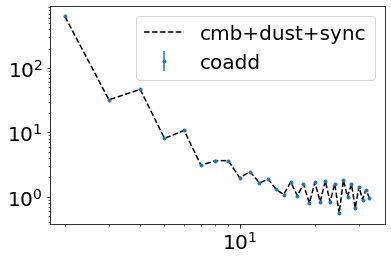

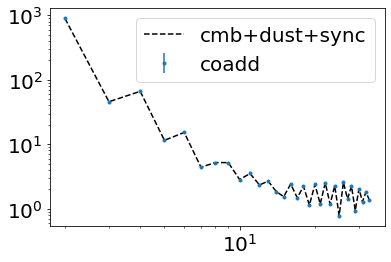

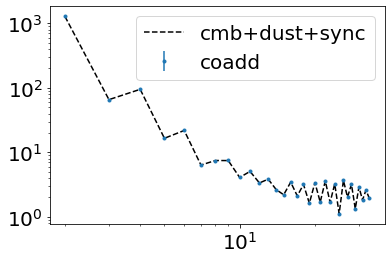

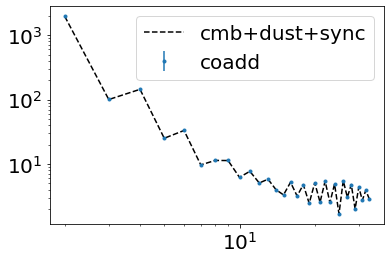

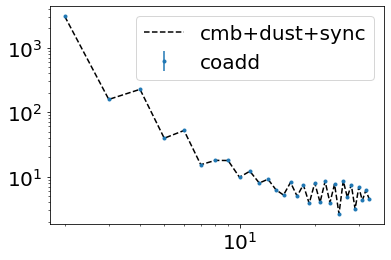

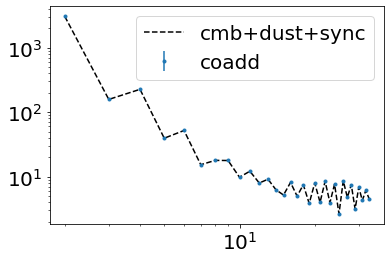

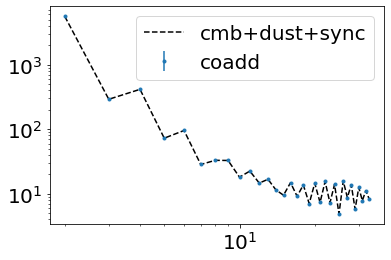

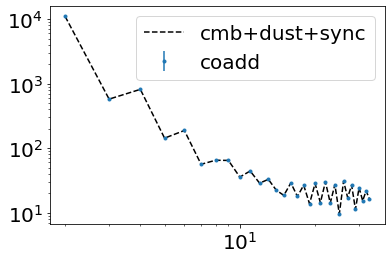

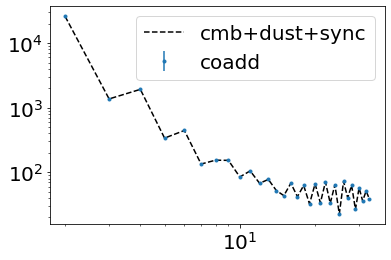

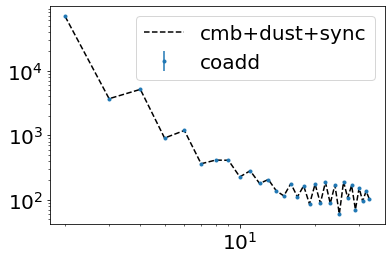

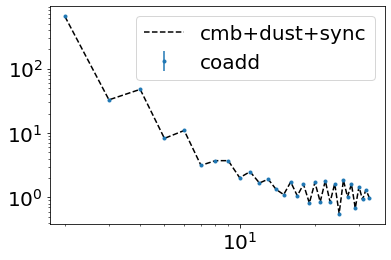

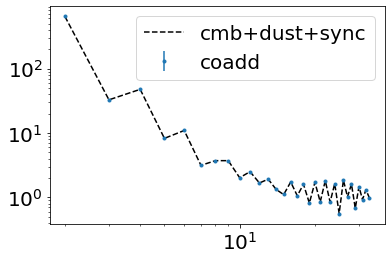

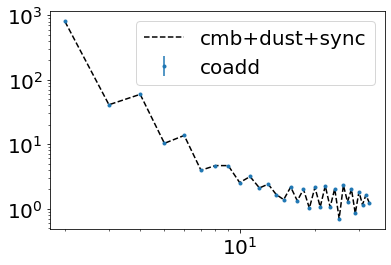

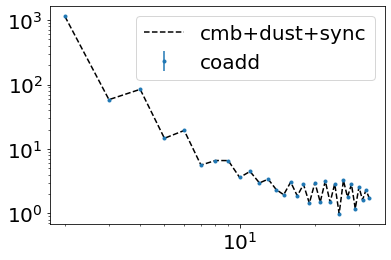

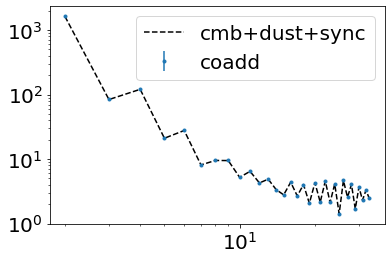

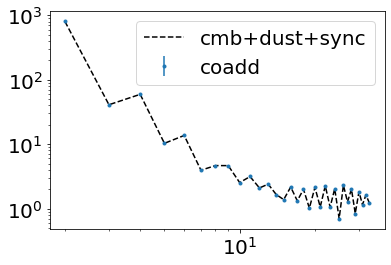

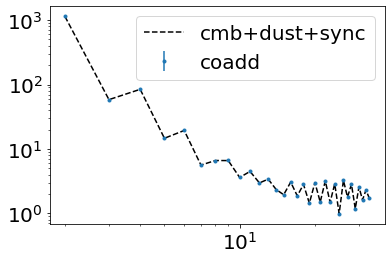

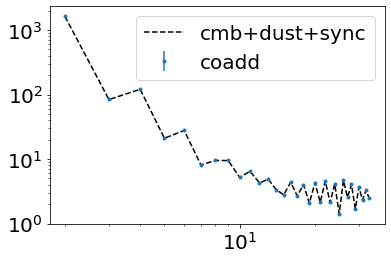

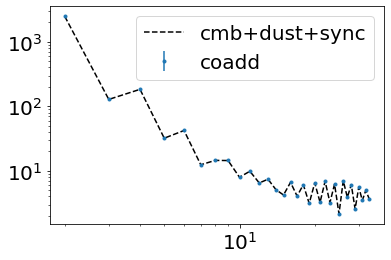

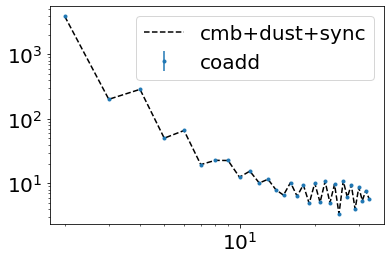

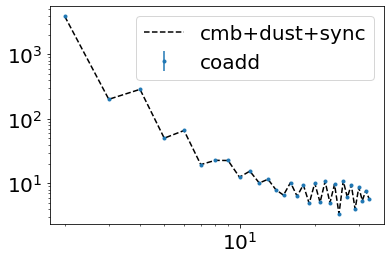

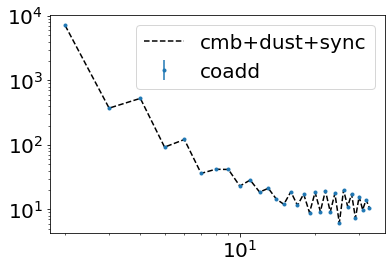

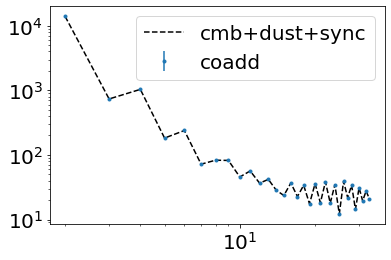

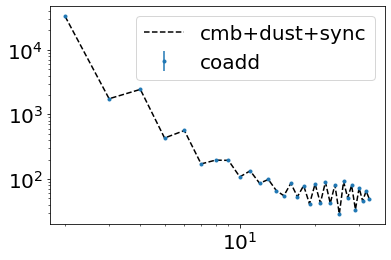

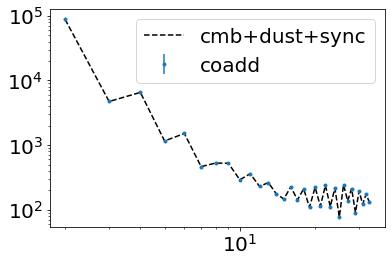

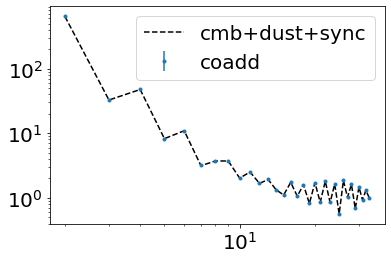

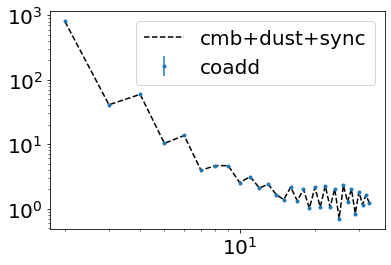

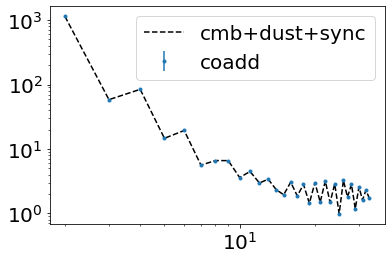

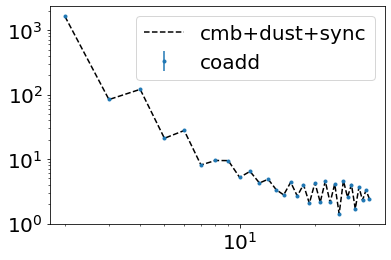

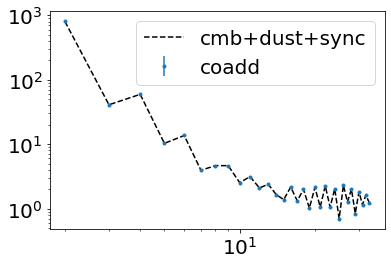

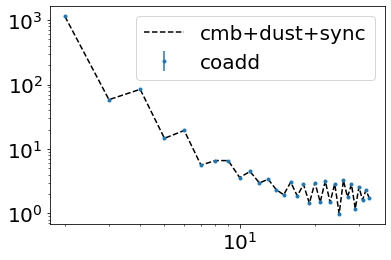

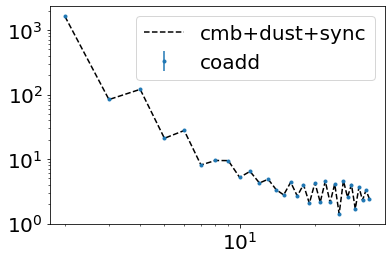

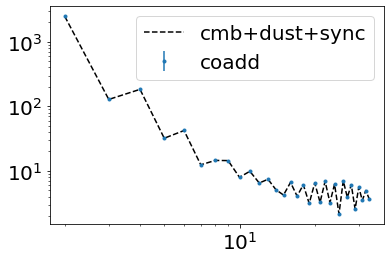

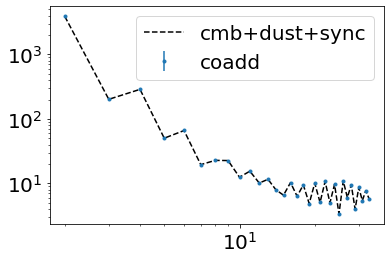

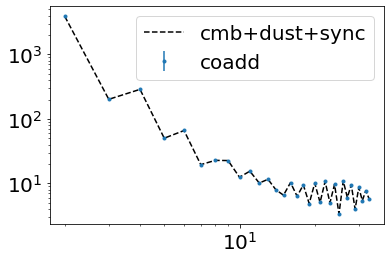

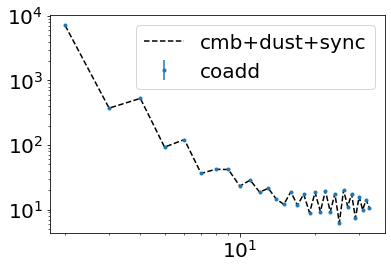

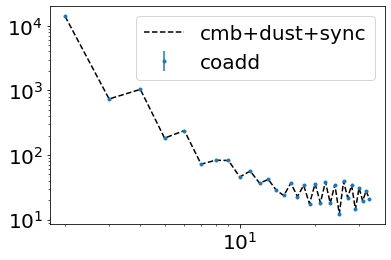

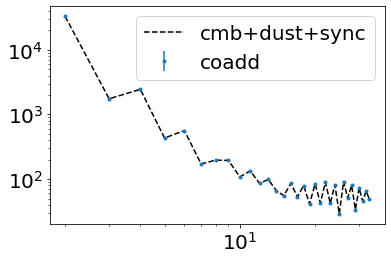

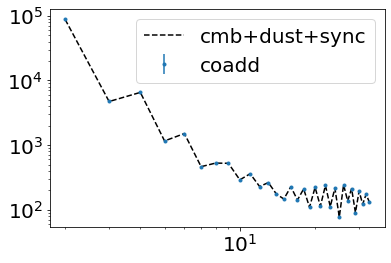

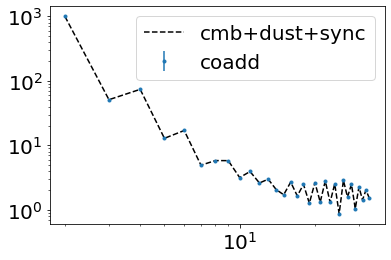

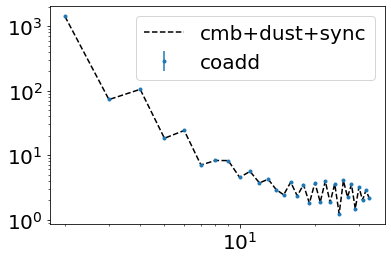

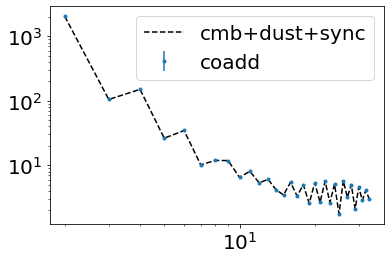

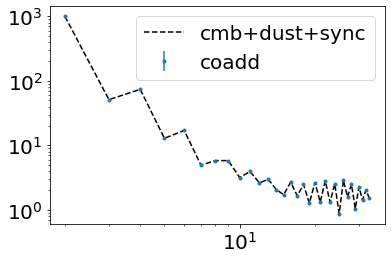

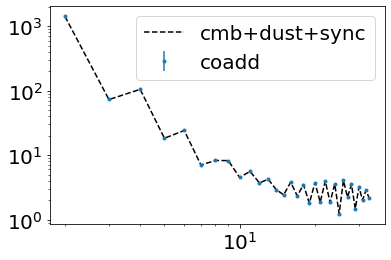

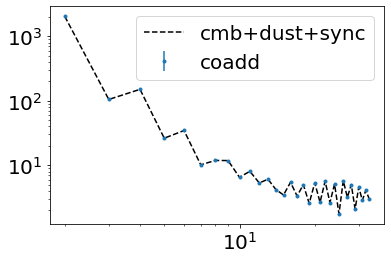

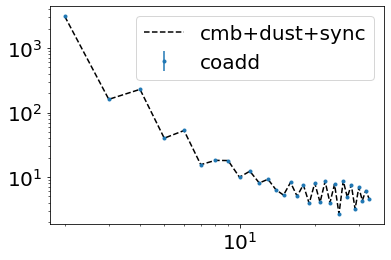

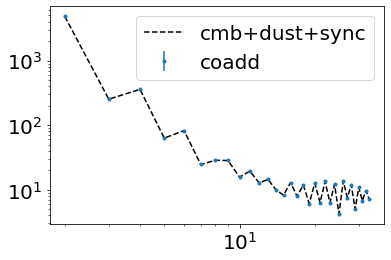

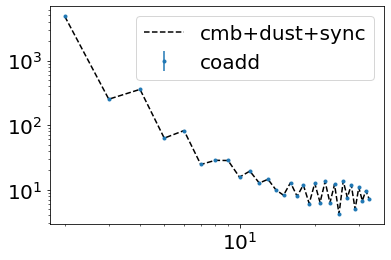

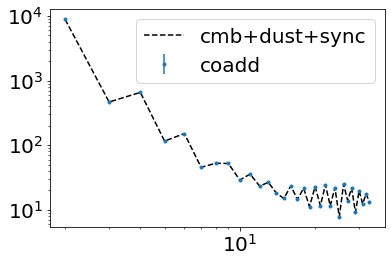

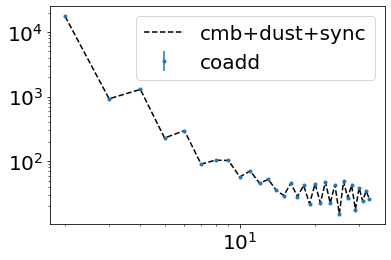

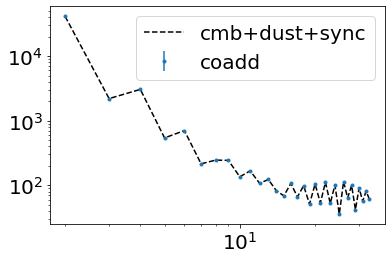

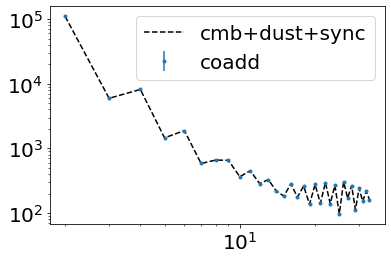

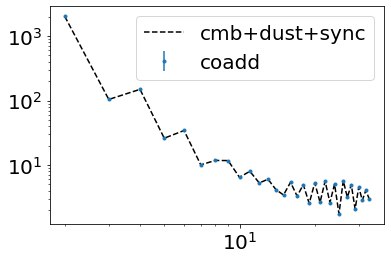

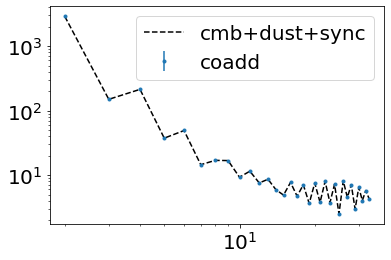

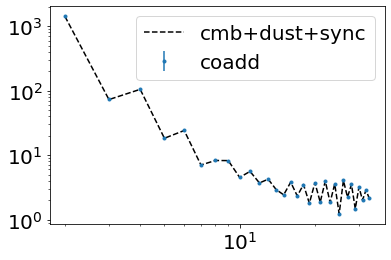

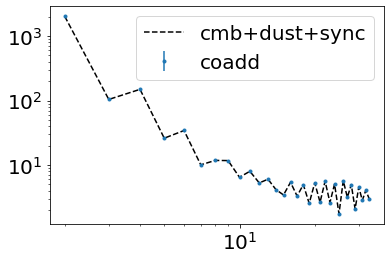

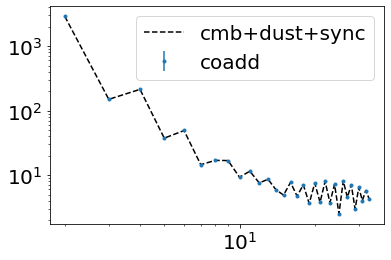

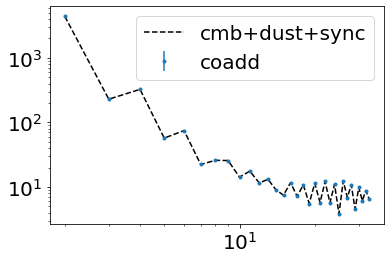

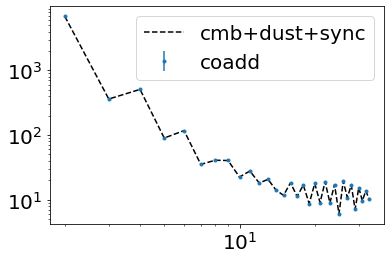

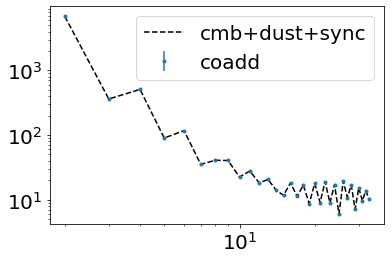

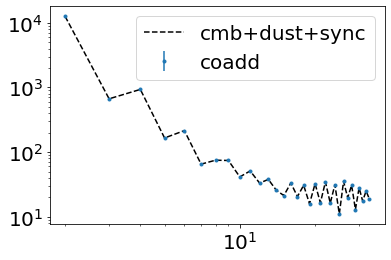

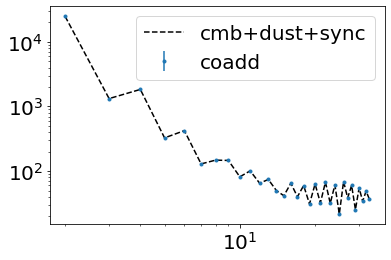

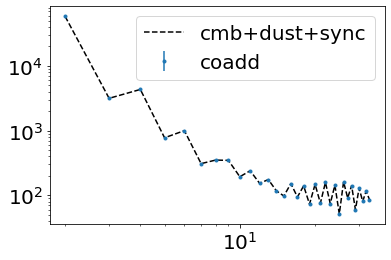

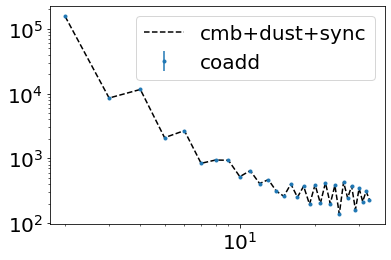

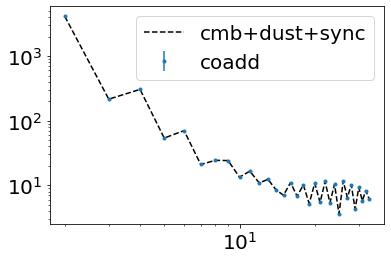

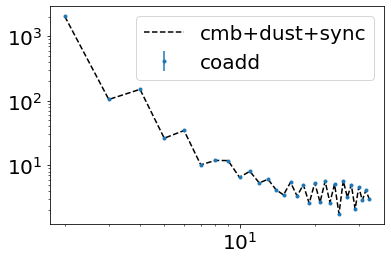

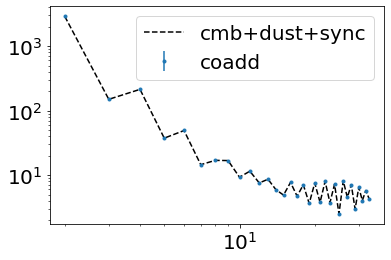

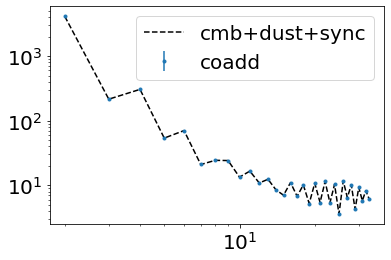

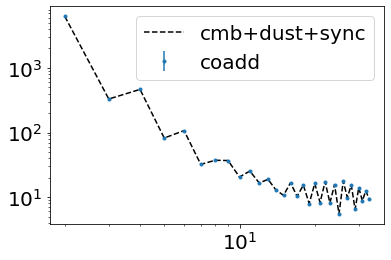

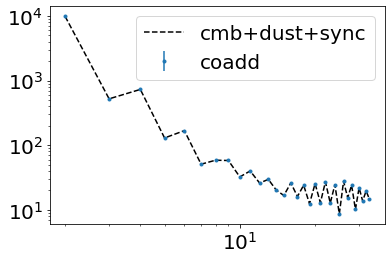

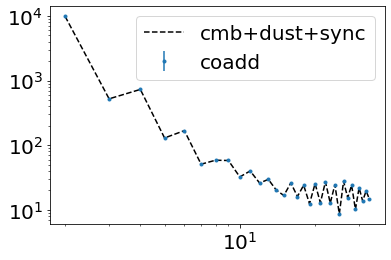

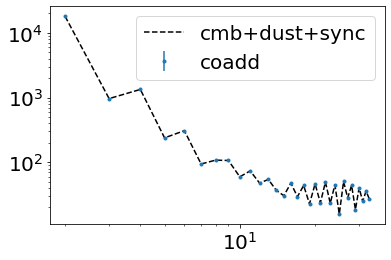

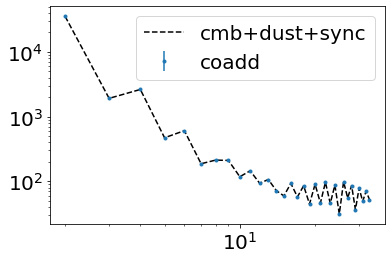

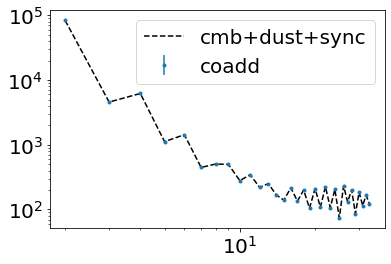

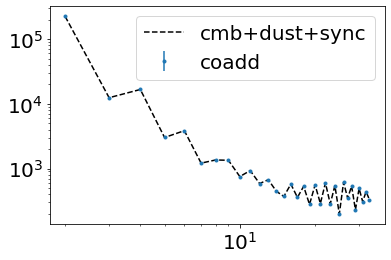

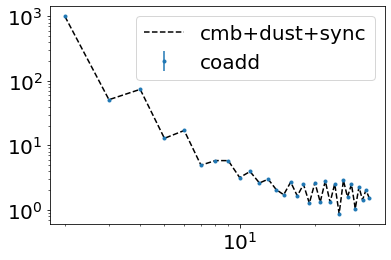

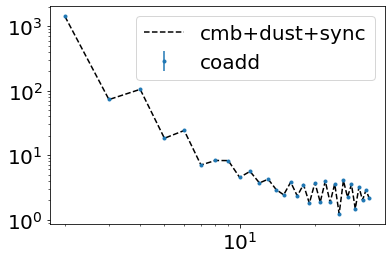

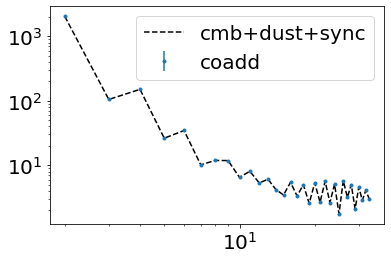

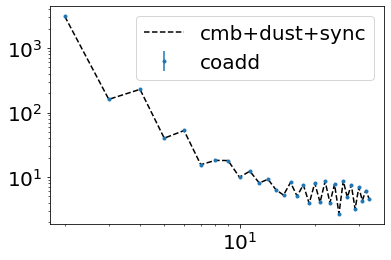

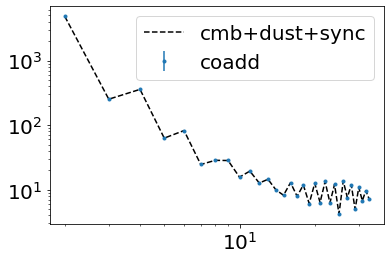

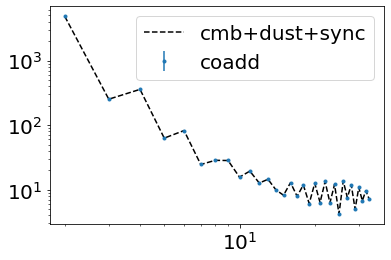

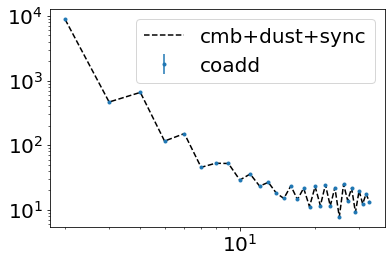

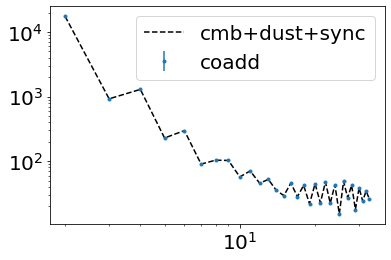

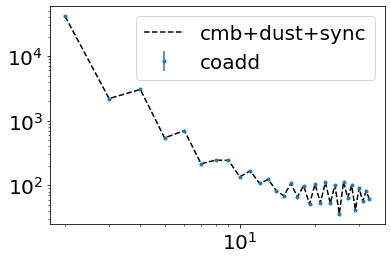

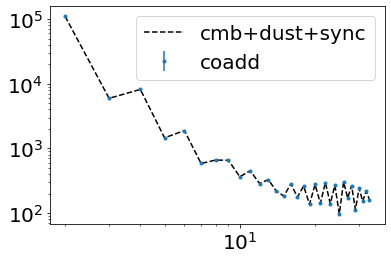

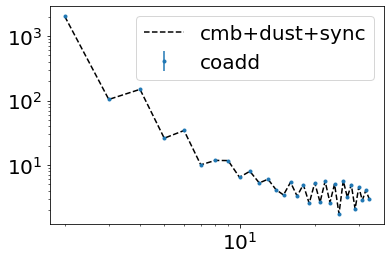

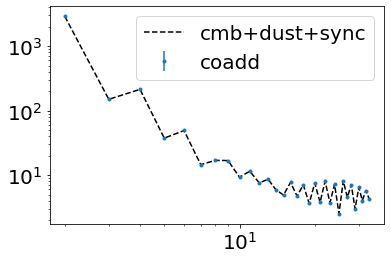

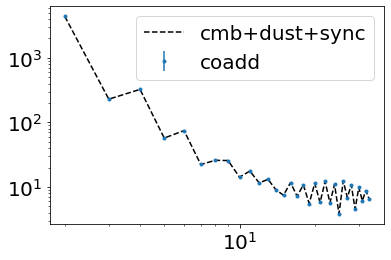

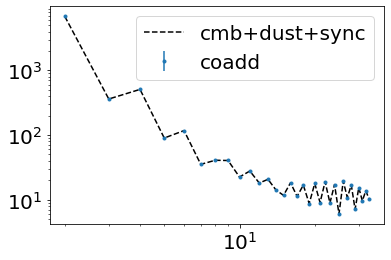

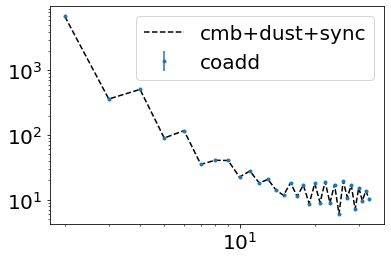

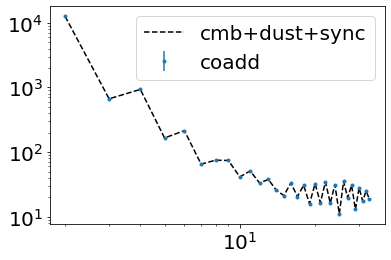

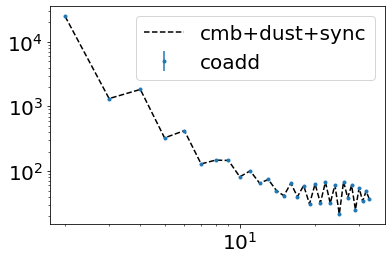

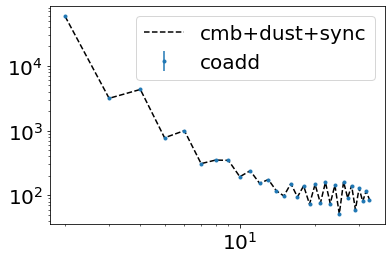

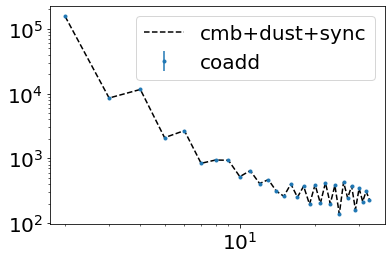

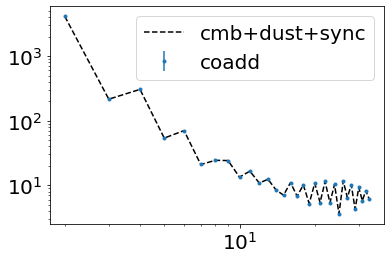

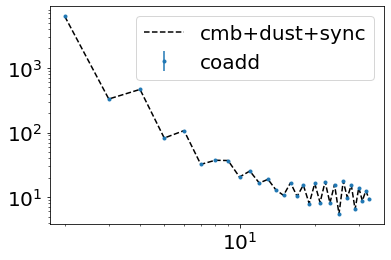

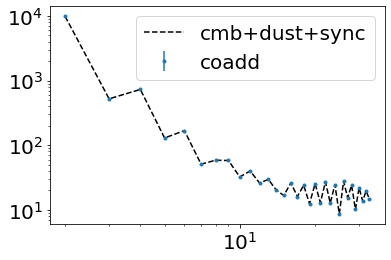

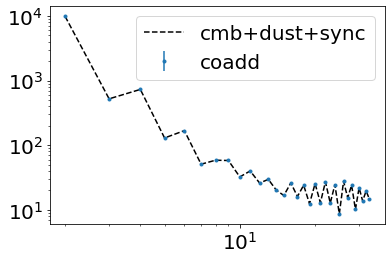

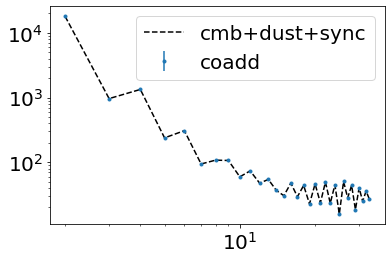

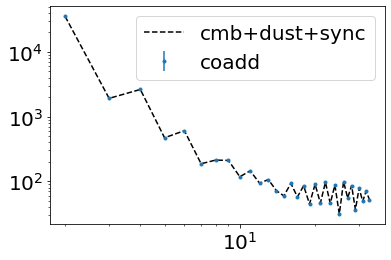

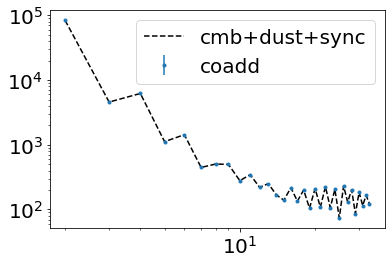

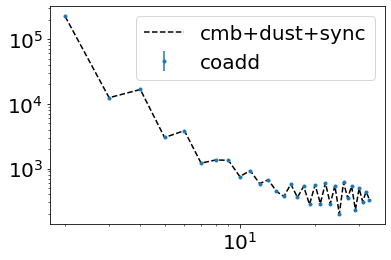

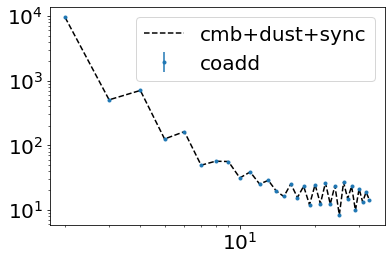

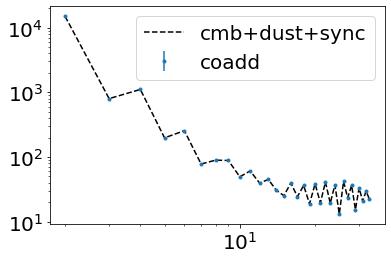

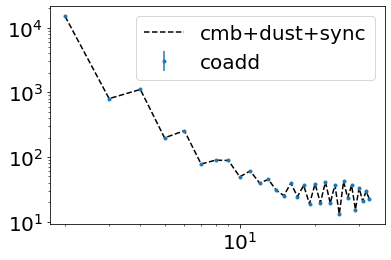

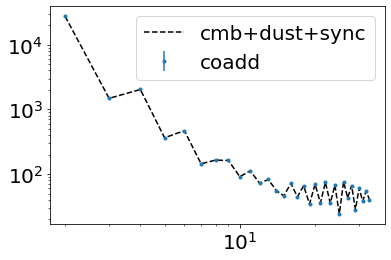

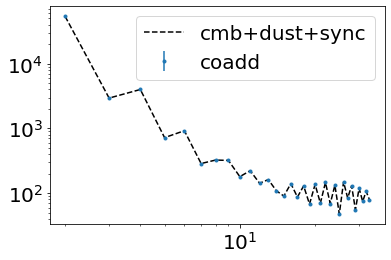

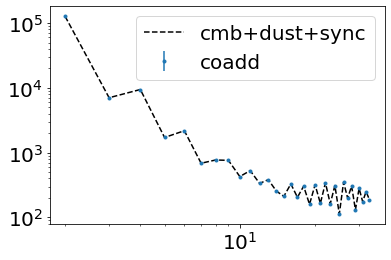

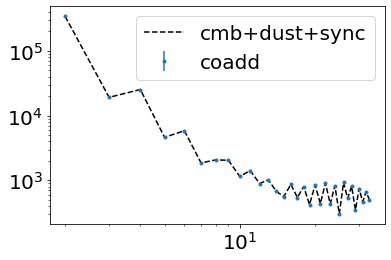

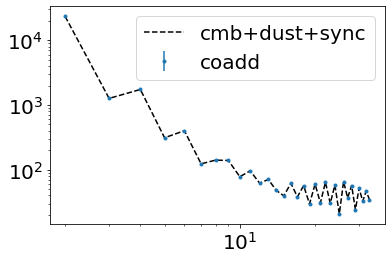

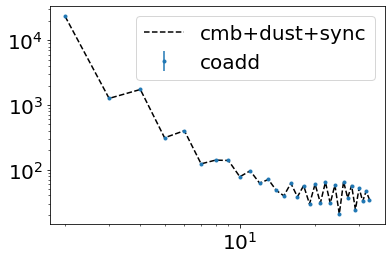

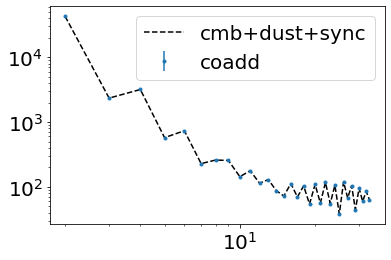

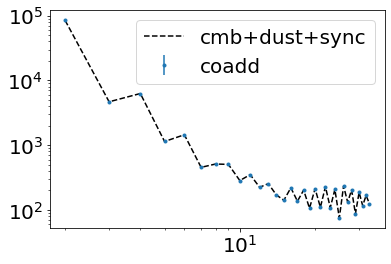

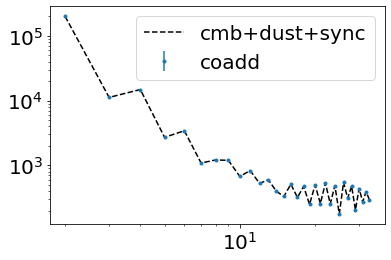

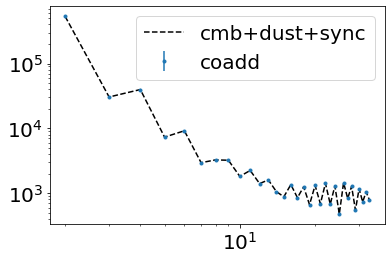

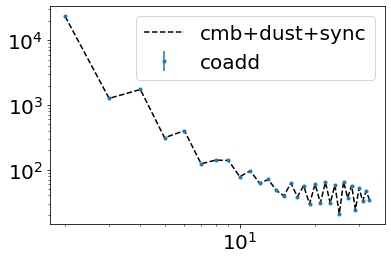

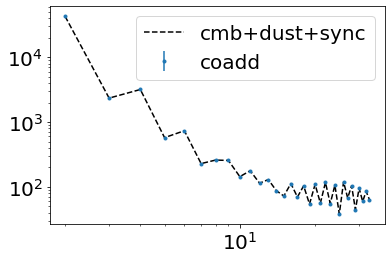

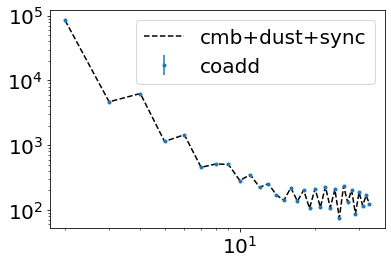

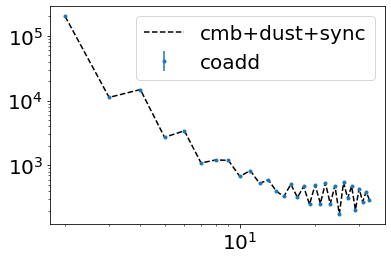

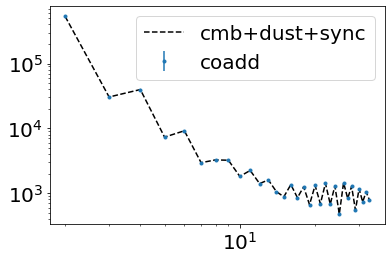

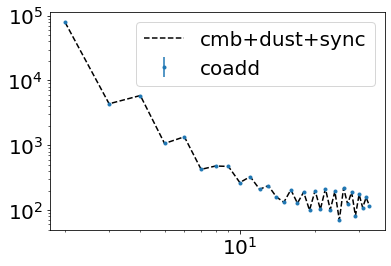

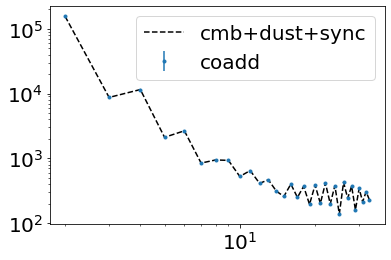

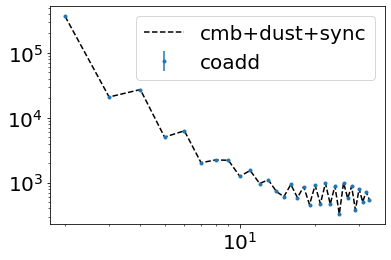

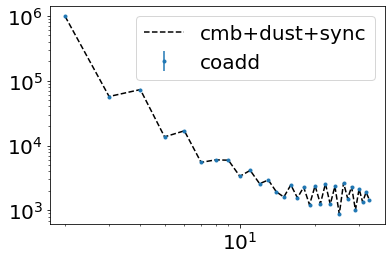

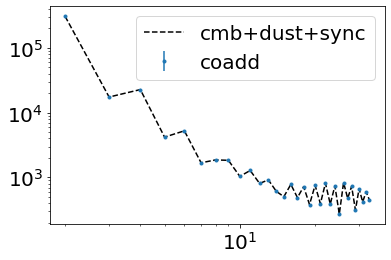

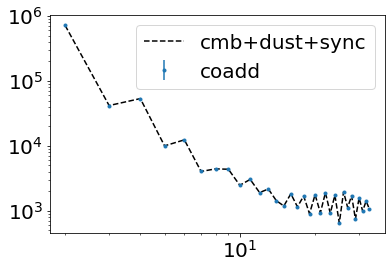

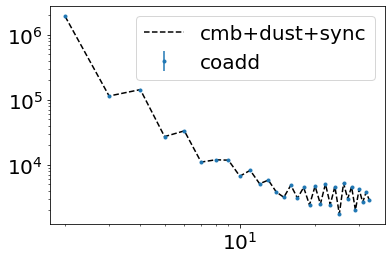

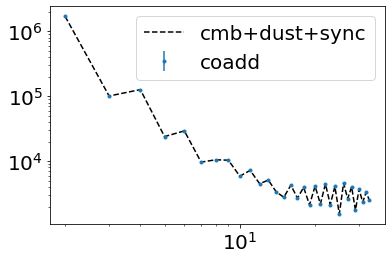

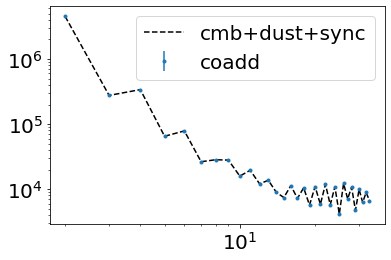

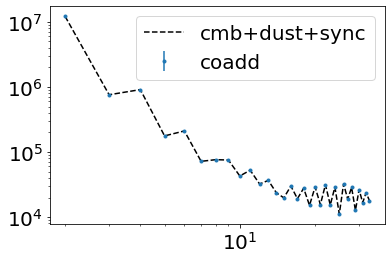

In [9]:
N=199
CLdcdust= np.load(Pr+'codes/Moments-EE/DL_EE/DL_EE_dust_%s_nside%s.npy'%(complexity,nside))/leff/(leff+1)*2*np.pi
for f in range(Ncross):
    #print(cross[f])
    #plt.plot(leff,leff*(leff+1)*CLcmb[1]/2/np.pi,label='cmb')
    #plt.plot(leff,leff*(leff+1)*CLdcdust[f]/2/np.pi,label='dust')
    #plt.plot(leff,leff*(leff+1)*CLdcsync[f]/2/np.pi,label='sync')
    plt.errorbar(leff,leff*(leff+1)*np.mean(CLdc[:N,f],axis=0)/2/np.pi,yerr=leff*(leff+1)*np.std(CLdc[:N,1],axis=0)/2/np.pi ,fmt='.',label='coadd')
    plt.plot(leff,leff*(leff+1)*(CLcmb_bin[1]+CLdcdust[f])/2/np.pi,label='cmb+dust+sync',c='k',linestyle='--')
    plt.legend()
    plt.loglog()
    plt.show()